In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
%matplotlib inline

from IPython.html.widgets import interact
from ipywidgets import GridspecLayout
import ipywidgets as widgets

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot,lag_plot

from statsmodels.tsa.stattools import adfuller,kpss,range_unit_root_test,zivot_andrews

from scipy.fftpack import fft,fftfreq,ifft

import datetime

Resampling, rolling calculations, and differencing

Identifying periodicity and correlation

This produces an autocorrelation plot: the correlation of a time series with itself at a range of lag times. We have applied it to the downsampled yearly time series which makes the calculation a lot quicker

In [2]:
bc = pd.read_csv('black_carbon.csv', na_values=('--'), parse_dates=["Datetime"])
#bc = pd.read_csv('D:/SERGIO/Python/black_carbon.csv', na_values=('--'), parse_dates=["Datetime"])
#bc = pd.read_csv('black_carbon.csv', na_values=('--'), parse_dates=["Datetime"])
bc= bc.set_index('Datetime')


bc['Year'] = pd.DatetimeIndex(bc.index).year
bc['Month'] = pd.DatetimeIndex(bc.index).month
bc['Day'] = pd.DatetimeIndex(bc.index).day
bc['Hour'] = pd.DatetimeIndex(bc.index).hour
bc['Weekday'] = pd.DatetimeIndex(bc.index).weekday

bc["BC"].fillna(bc["BC"].mean(), inplace=True)

bc[bc['BC']<0.01] = 0.01
bc.head()

,T_amb,wind_speed,wind_dir,sc550,AE_450_700,PM10,BC,Year,Month,Day,Hour,Weekday
Datetime,,,,,,,,,,,,
2007-04-24 12:00:00,23.98,1.63,202.81,87.62,1.42935,63.89272,2.47,2007.0,4.0,24.0,12.0,1.0
2007-04-24 13:00:00,24.99,1.73,201.25,77.56,1.46802,63.51981,2.29,2007.0,4.0,24.0,13.0,1.0
2007-04-24 14:00:00,24.73,1.60,214.79,78.38,1.54528,59.83932,2.84,2007.0,4.0,24.0,14.0,1.0
2007-04-24 15:00:00,24.59,1.25,205.39,75.74,1.56389,61.13641,2.45,2007.0,4.0,24.0,15.0,1.0
2007-04-24 16:00:00,25.82,1.49,209.38,77.56,1.55272,66.60039,2.46,2007.0,4.0,24.0,16.0,1.0


In [3]:
hourly = bc.copy()

daily = hourly.resample("D").mean()
daily_sd = hourly.resample("D").std()


weekly = hourly.resample("W").mean()
weekly_sd = hourly.resample("W").std()

monthly = hourly.resample("M").mean()
monthly_sd = hourly.resample("M").std()

quarterly = hourly.resample("Q").mean()
quarterly_sd = hourly.resample("Q").std()


yearly =hourly.resample("Y").mean()
yearly_sd = hourly.resample("Y").std()


samples_list = [hourly, daily, weekly, monthly, quarterly, yearly]


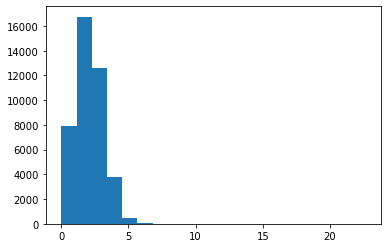

In [1054]:
plt.hist(hourly.wind_speed, bins = 20);
#plt.scatter(daily.BC,daily.PM10)

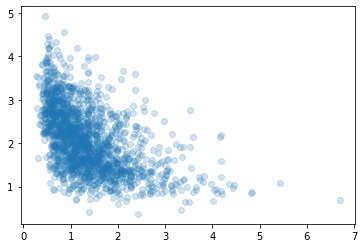

In [723]:
plt.scatter(daily.BC,daily.wind_speed,alpha = 0.2)

In [912]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.html.widgets import interact

### Time series of BC hourly measurements

- The period of analysis can be selected.
- resampling time can be chosen 

- Time series of BC daily values (adjustable time period)
- resampled time series (adjustable number of days to average)
- diff time series (adjustable number of lag days for the difference)
- 2 different Unit root/stationarity tests (statistics are presented which vary depending on the time span chosen and resample dyas used) 
- autocorrelation of ts and diff_ts (adjustable number of lags for visualization)

We can see by eye that there is an approximately 10 year cycleWe can see by eye that there is an approximately 10 year cycle

In [16]:


def my_figure1(n_days=14, yi=2007, yf=2012, lags = 50, dt_diff=0):


    ts1 = daily.BC[str(yi):str(yf)]
    ts2 = daily.BC[str(yi):str(yf)].resample(str(n_days)+'D').mean()
    ts3 = daily.BC[str(yi):str(yf)].resample(str(n_days)+'D').std()
    ts4 = daily.BC[str(yi):str(yf)].resample(str(n_days)+'D').median()
    
    ts_diff = ts2 - ts2.shift(dt_diff)
    ts_diff.dropna(inplace = True)
    
#     print(ts2.head())
#     print(ts2.tail())
#------------ Results of kpss test and result----------------------------      
    
    k_test =  kpss(ts2, regression ='ct')
   
    koutput = pd.Series(k_test[0:2], index = ['Test Statistic','p-value'])
   
    for key,value in k_test[3].items():
        koutput['Critical Value (%s)'%key] = value
#     print('-------------------'*3)    
#     print('Results of KPSS test:')
#     print(koutput)
#     print('-------------------'*3)

    
#------------ Results of adfuller test and result----------------------------  


    af = adfuller(ts2, regression = 'ctt', autolag = 'AIC')
    
    dfoutput = pd.Series(af[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
   
    for key,value in af[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print('-------------------'*3)    
    print('Results of Dickey-Fuller Test:')
#    print(dfoutput)
    print('-------------------'*3)

#------------ Plotting time series----------------------------

    
    fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,7))
    
    ax1.set_title('Time series \n Hourly BC measurements')
    ax1.set_facecolor('whitesmoke')
    
    
    
#    ax.scatter(ts1.index,ts1,c='black',alpha=0.1, label = 'hourly values, initial data')
    ax1.plot(ts1,c='black',alpha=0.22, label = 'hourly values, initial data')
    ax1.plot(ts2, c='darkblue',linewidth = 2, label = 'resampled values, mean') 
    ax1.plot(ts4, c='blue',linewidth = 2, alpha =1, label = 'resampled values, median')
    
    ax1.fill_between(ts2.index,ts2-ts3, ts2+ts3, alpha = 0.5,  label = 'std')
    ax1.plot(ts2+ts3, c = 'darkblue', linewidth = .5, alpha=1)
    ax1.plot(ts2-ts3, c = 'darkblue', linewidth = .5, alpha=1)
    
    ax1.set_ylim(0,(ts2+ts3).max()+2)    
    ax1.legend( loc='best', shadow=True, fontsize='medium')

    
    ax3.plot(ts_diff, c='darkblue',linewidth = 2, label = 'diff')
    ax3.set_title('Difference ts for selected \n resampling period, time span and lag')
    ax3.set_facecolor('whitesmoke')
    ax3.legend( loc='best', shadow=True, fontsize='medium')

    ax2.set_title('Autocorrelation for selected \n resampling period and time span')
    ax2.set_facecolor('whitesmoke')
    autocorrelation_plot(ts2,ax=ax2)
#     plot_acf(ts2, lags = lags ,label = 'acf',ax = ax2)
#     plot_pacf(ts2, lags = lags ,method='ywm',label = 'pacf',ax = ax2)
#    ax2.legend( loc='best', shadow=True, fontsize='medium')
    ax2.set_xlim(0,lags) 
    
    
    ax4.set_title('Autocorrelation diff for selected: \n -resampling period, time span and lag')
    ax4.set_facecolor('whitesmoke')
    autocorrelation_plot(ts_diff,ax=ax4)
#     plot_acf(ts_diff, lags = lags ,label = 'acf', c = 'green',ax = ax4)
#     plot_pacf(ts_diff, lags = lags ,method='ywm',label = 'pacf',ax = ax4)
#    ax4.legend( loc='best', shadow=True, fontsize='medium')
    ax4.set_xlim(0,lags)
    
    
n_days = widgets.IntSlider(value=14,min=2,max=180,step=2,description='n days : ',disabled=False,continuous_update=False,
                           orientation='horizontal', readout=True, readout_format='d')

lags = widgets.IntSlider(value=50,min=2,max=100,step=1,description='Lag : ',disabled=False,continuous_update=False,
                           orientation='horizontal', readout=True, readout_format='d')

dt_diff = widgets.IntSlider(value=0,min=0,max=60,step=1,description='day diff : ',disabled=False,continuous_update=False,
                           orientation='horizontal', readout=True, readout_format='d')

# import datetime
# dates = [datetime.date(2015, i, 1) for i in range(1, 13)]
# options = [(i.strftime('%b'), i) for i in dates]
# widgets.SelectionRangeSlider(
#     options=options,
#     index=(0, 11),
#     description='Months (2015)',
#     disabled=False
# )
    
interact(my_figure1 , n_days=n_days, yi=(2007,2012), yf=(2007,2012), lags = lags, dt_diff = dt_diff);

interactive(children=(IntSlider(value=14, continuous_update=False, description='n days : ', max=180, min=2, st…

In [1050]:
dates = [datetime.date(2015, i, 1) for i in range(1, 13)]
dates[1]

datetime.date(2015, 2, 1)

# Spectral analysis and Filtering a signal using FFT

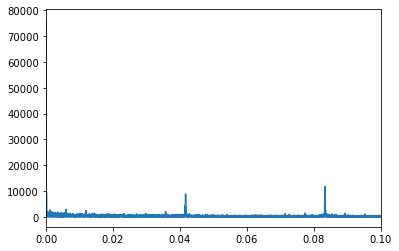

In [908]:


yf = fft(np.array(hourly.BC))
xf = fftfreq(len(np.array(hourly.BC)), 1)

plt.plot(xf, np.abs(yf))


plt.xlim(0, .1)
plt.show()


In [827]:
from scipy.fft import rfft, fft

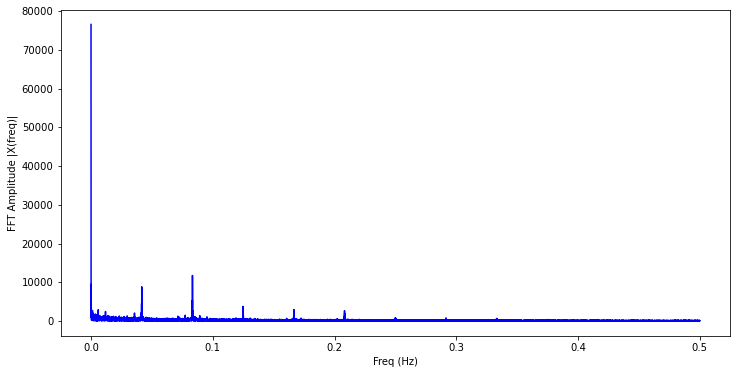

In [832]:
X = fft(np.array(hourly.BC))
N = len(X)
n = np.arange(N)
# get the sampling rate
sr = 1 
T = N/sr
freq = n/T 

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]


plt.figure(figsize = (12, 6))
plt.plot(f_oneside, np.abs(X[:n_oneside]), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.show()

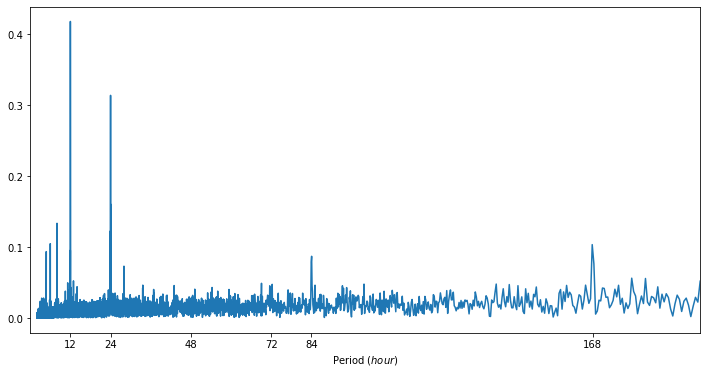

In [837]:
t_h = 1/f_oneside 

plt.figure(figsize=(12,6))
plt.plot(t_h, np.abs(X[:n_oneside])/n_oneside)
plt.xticks([12, 24, 48, 72, 84, 168])
plt.xlim(0, 200)
plt.xlabel('Period ($hour$)')
plt.show()

In [13]:



def my_figure2(cut_off_l = 7e-3,cut_off_h = 0.004, window = 1):

    
    t = np.arange(len(np.array(hourly.BC[:'2011'])))
    roll_data = hourly.BC[:'2011'].rolling(window, min_periods=1).mean()
    
#   print(cut_off)
    # FFT the signal
    sig_fft = fft(np.array(hourly.BC[:'2011']))
    # copy the FFT results
    sig_fft_filtered_low = sig_fft.copy()
    sig_fft_filtered_high = sig_fft.copy()
    # obtain the frequencies using scipy function
    freq_low = fftfreq(len(np.array(hourly.BC[:'2011'])), d=1)
    freq_high = fftfreq(len(np.array(hourly.BC[:'2011'])), d=1)
    # define the cut-off frequency
    #cut_off = 0.0006

    # low-pass filter 

    sig_fft_filtered_low[(np.abs(freq_low)) > (cut_off_l)] = 0
    
    sig_fft_filtered_high[(np.abs(freq_high)) < (cut_off_h)] = 0

    # get the filtered signal in time domain
    filtered_low = ifft(sig_fft_filtered_low)
    filtered_high = ifft(sig_fft_filtered_high)

    # plot the filtered signal
    fig, (ax_low,ax_high, ax_roll) = plt.subplots(3,1, figsize = (12, 7))
    
    ax_low.set_title('Low Pass Filter on the signal, cutoff = ' + str(round(365*cut_off_l,6))+ '(day)')
    ax_low.plot(t,hourly.BC[:'2011'], c='black', alpha = 0.1)
    ax_low.plot(t, filtered_low, c = 'blue',linewidth = 2.5)
    ax_low.set_xlim(-500,35000)
    ax_low.set_ylim(0, filtered_low.max()+1)
    
    ax_low.set_xlabel('Time (h) ')
    ax_low.set_ylabel('Amplitude')

    ax_high.set_title('High Pass Filter on the signal, cutoff = ' + str(round(365*cut_off_h,6))+ '(day)')
    ax_high.plot(t,hourly.BC[:'2011'], c='black', alpha = 0.1)
    ax_high.plot(t, filtered_high, c = 'blue',linewidth = 2.5)
    ax_high.set_xlim(-500,35000)
    ax_high.set_ylim(0, filtered_high.max()+1)
    
    ax_high.set_xlabel('Time (h) ')
    ax_high.set_ylabel('Amplitude')
    
    ax_roll.set_title('Rolling average = ' + str(window))
    ax_roll.plot(t,hourly.BC[:'2011'], c='black', alpha = 0.1)
    ax_roll.plot(t,roll_data, c='black',linewidth = 2.5)
    ax_roll.set_xlim(-500,35000)
    ax_roll.set_ylim(0, 15)
    
    ax_roll.set_xlabel('Time (h) ')
    ax_roll.set_ylabel('Amplitude')
    
    
    
    
    # plot the FFT amplitude before and after
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (12, 3))
    
    ax1.stem(1/freq_low, np.abs(sig_fft), 'b', markerfmt=" ", basefmt="-b")
    ax1.set_title('Before filtering')
    ax1.set_xticks([12, 24, 48, 72, 84, 168])
    ax1.set_xlim(0, 200)
    ax1.set_ylim(0, 10000)
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('FFT Amplitude')

    
    ax2.stem(freq_low, np.abs(sig_fft_filtered_low), 'b', markerfmt=" ", basefmt="-b")
    ax2.axvline(cut_off_l,c='black')
    ax2.set_title('After filtering')
    ax2.set_xlim(0, cut_off_l+0.01)
    ax2.set_ylim(0, 20000)
    ax2.set_xlabel('Frequency (Hour-1)')
    ax2.set_ylabel('FFT Amplitude');
    
    ax3.stem(freq_high, np.abs(sig_fft_filtered_high), 'b', markerfmt=" ", basefmt="-b")
    ax3.axvline(cut_off_h,c='black')
    ax3.set_title('After filtering')
    ax3.set_xlim(0, cut_off_l+0.01)
    ax3.set_ylim(0, 20000)
    ax3.set_xlabel('Frequency (Hour-1)')
    ax3.set_ylabel('FFT Amplitude');
    
    
cut_off_l = widgets.FloatLogSlider(value=1e-3,base=10,min=-5, max=1, step=0.01, description='Low Pass cut off', orientation='horizontal', readout_format='.5f')

cut_off_h = widgets.FloatLogSlider(value=0.004,base=10,min=-6, max=-0.30, step=0.01, description='High Pass cut off', orientation='horizontal', readout_format='.5f')

window = widgets.IntSlider(value=1,min=1,max=1000,step=1,description='rolling window : ',disabled=False,continuous_update=False,
                           orientation='horizontal', readout=True, readout_format='d')


#interact(my_figure2 , cut_off=(0.0001, 0.5,1e-5));
interact(my_figure2 ,cut_off_l=cut_off_l,cut_off_h=cut_off_h, window=window )

interactive(children=(FloatLogSlider(value=0.001, description='Low Pass cut off', max=1.0, min=-5.0, readout_f…

<function __main__.my_figure2(cut_off_l=0.007, cut_off_h=0.004, window=1)>

In [1110]:
1/24, 1/(24*365)

(0.041666666666666664, 0.00011415525114155251)

In [1015]:
w = widgets.IntSlider()
display(w)
display(w)

IntSlider(value=0)

IntSlider(value=0)

In [644]:
ts_diff = bc.resample("W").mean().BC - bc.resample("W").mean().BC.shift()
ts_diff.dropna(inplace = True)

def my_plot1(lagg=20):

    autocorrelation_plot(ts_diff[:lagg])

#adfuller(ts_diff, regression = 'ctt', autolag = 'AIC')[1]

interact(my_plot1, lagg=(2, 70));

interactive(children=(IntSlider(value=20, description='lagg', max=70, min=2), Output()), _dom_classes=('widget…

In [625]:
interact(f, x='Hi there!');

interactive(children=(Text(value='Hi there!', description='x'), Output()), _dom_classes=('widget-interact',))

stationary in 2007-2009? The null hypetesis is that the series is non stationary. Low p value means that H0 should be rejected, therefore the series is stationary

In [ ]:
orig = plt.plot(timeseries, color = 'blue',label = 'Original')

In [668]:
kpss(bc.BC['2007':'2009'], regression='c')#, regression='c', nlags='auto', store=False)

(1.162281898108684,
 0.01,
 70,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [271]:
zivot_andrews(bc.BC['2007'])

(-10.393959013131209,
 1e-05,
 {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618},
 25,
 1256)

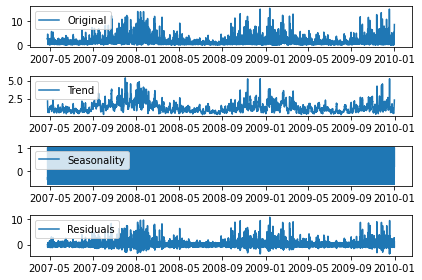

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(bc.BC['2007':'2009'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(bc.BC['2007':'2009'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [287]:
numIters = 8

axiom = "A"         ## initial word 
#rule = ['B','AB']

startString = axiom   ## startString is the initial word

list_strings = []

for iteration in range(1, numIters):

    newstr = ""
    
    for ch in startString:
        
        if ch == 'A':            
            newstr = newstr + 'B' # Rule 1
            
        elif ch == 'B':            
            newstr = newstr + 'AB' # Rule 2
            
#         else:            
#              newstr = ch    # no rules apply so keep the character    
#         endString = newstr 
        
#         startString = endString
        startString = newstr
       
    list_strings.append(startString)
        
        
        
#print(endString)

    print(list_strings)

['B']
['B', 'AB']
['B', 'AB', 'BAB']
['B', 'AB', 'BAB', 'ABBAB']
['B', 'AB', 'BAB', 'ABBAB', 'BABABBAB']
['B', 'AB', 'BAB', 'ABBAB', 'BABABBAB', 'ABBABBABABBAB']
['B', 'AB', 'BAB', 'ABBAB', 'BABABBAB', 'ABBABBABABBAB', 'BABABBABABBABBABABBAB']
